I have taken inspiration from kaggle “Brain Tumor Resunet” by Omnia (2022), to implement my work.

# Importing and Installing Dependencies 

Download the dataset from the link --> "https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation?select=BraTS2020_TrainingData", and unzip it.

In [ ]:
!pip install nilearn
!pip install pydot
!pip install graphviz

In [ ]:
# Importing all the necessary libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input ,BatchNormalization , Activation 
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting

In [ ]:
# Verifying if we have access to GPU or not.

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version:  2.8.0
Keras version:  2.8.0
Num GPUs Available:  0


# Getting to know the Dataset.


Now before running the next line of codes, please go to the path "BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/" inside the dataset folder and go to "BraTS20_Training_355" and inside of that youll find 5 .nii files. There should be 4 files ending with t1, t1ce, t2, flair. However, the last remaining file, please rename it to "BraTS20_Training_355_seg.nii". We do this so that every image is consistent throughout and all have 5 files ending with t1, t1ce, t2, flair and seg.

Loading sample images from dataset for visualization.

In [ ]:
image_flair= nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_flair.nii')
image_mask= nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_seg.nii')
image_t1= nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_t1.nii')
image_t1ce= nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_t1ce.nii')
image_t2= nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_t2.nii')

Fluid-attenuated inversion recovery (FLAIR):
Fluid-attenuated inversion recovery (FLAIR) is an MRI technique that shows areas of tissue T2 prolongation as bright while suppressing (darkening) cerebrospinal fluid (CSF) signal, thus clearly revealing lesions in proximity to CSF, such as cerebral cortical lesions.

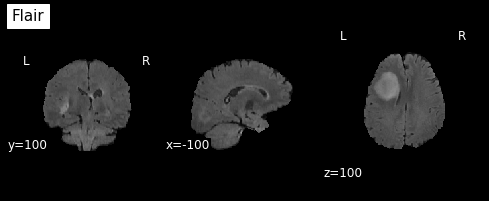

In [ ]:
plotting.plot_anat(image_flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

T1 weighted images: A T1-weighted (T1W) image is a basic pulse sequence in magnetic resonance (MR) imaging and depicts differences in signal based upon intrinsic T1 relaxation time of various tissues.

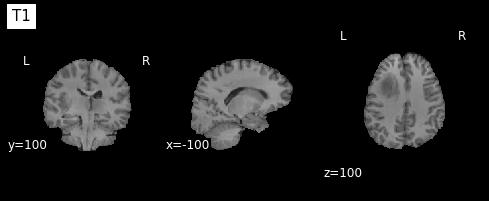

In [ ]:
plotting.plot_anat(image_t1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

T1-weighted contrast-enhanced: Standard imaging also can identify other important characteristics of the mass in situ, including the volume of various tumor sub-regions (i.e., necrotic, enhancing, and non-enhancing), compression of the surrounding peritumoral tissue, and midline deviation.

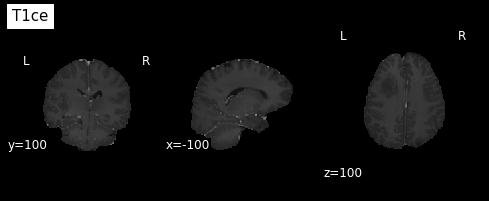

In [ ]:
plotting.plot_anat(image_t1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

T2 weighted images: A T2-weighted image is a basic pulse sequences in magnetic resonance (MR) imaging that depicts differences in the T2 relaxation time of various tissues.

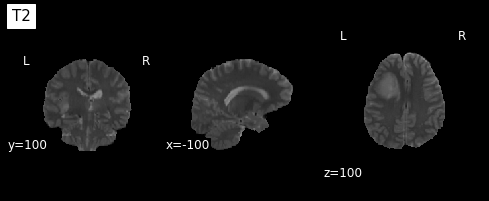

In [ ]:
plotting.plot_anat(image_t2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

Manual segmentation that annotated by an expert:

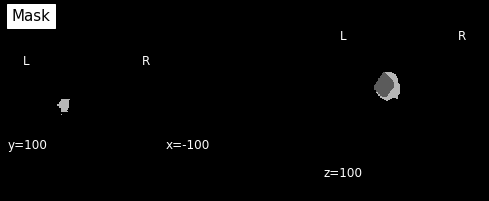

In [ ]:
plotting.plot_anat(image_mask,cut_coords=[-100, 100, 100],title="Mask",draw_cross =False)

Viewing whole nifti data, printing each slice from image.

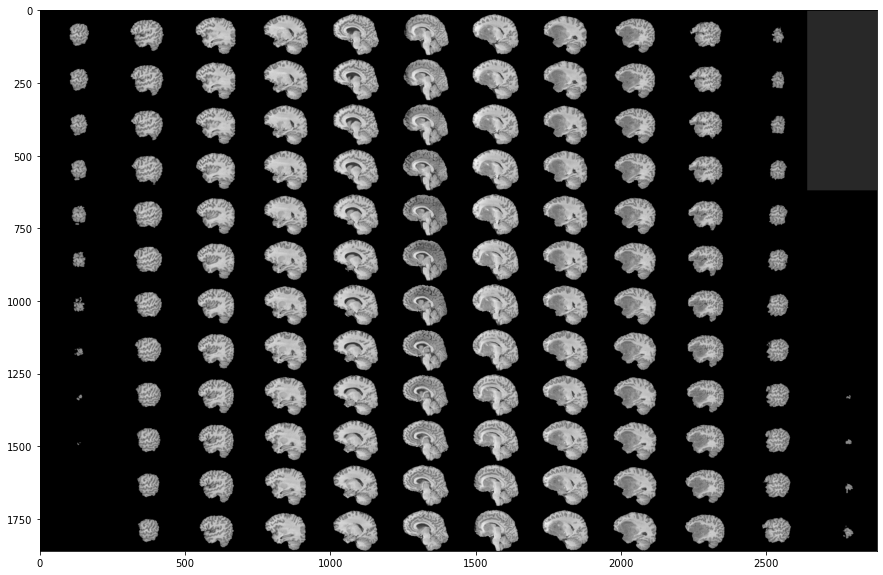

In [ ]:
from skimage.util import montage 
from skimage.transform import rotate
image_t1 = nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_t1.nii').get_fdata()
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

Viewing segment of tumor for each of the above slices.

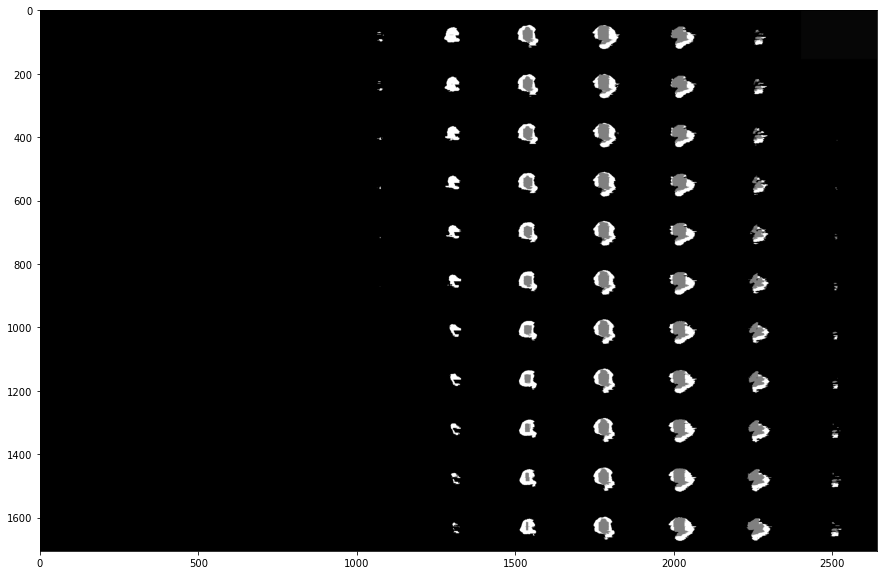

In [ ]:
# Skip 50:-50 slices since there is not much to see
image_t1_mask = nib.load('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335/BraTS20_Training_335_seg.nii').get_fdata()
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

# Data Pre-processing.

In [ ]:
#Load the path of the dataset stored on your machine.
Path= '/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []

def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities

for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)

Verifying if the images and their corresponding mask are stored properly.

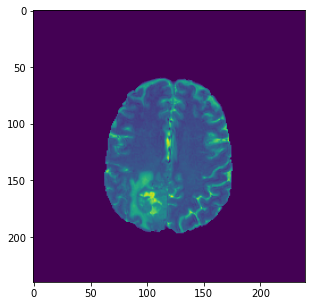

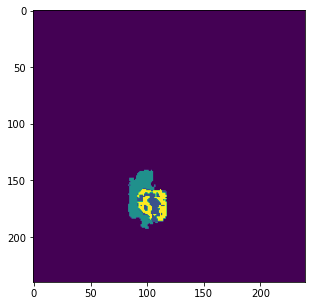

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[2][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

fig = plt.figure(figsize=(5,5))
immmg = Input_Data[2][100,:,:,4]
imgplot = plt.imshow(immmg)
plt.show()

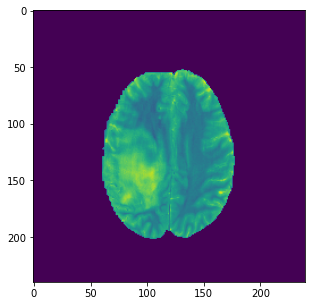

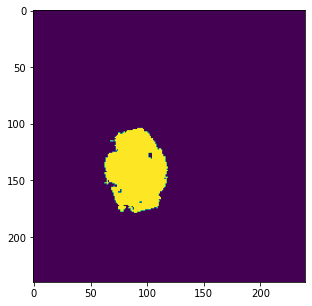

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[10][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

fig = plt.figure(figsize=(5,5))
immmg = Input_Data[10][100,:,:,4]
imgplot = plt.imshow(immmg)
plt.show()

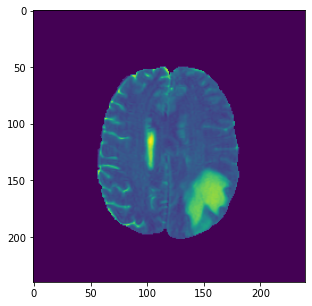

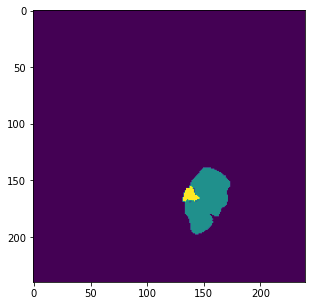

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[18][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

fig = plt.figure(figsize=(5,5))
immmg = Input_Data[18][100,:,:,4]
imgplot = plt.imshow(immmg)
plt.show()

Concatenating the data.

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
InData= Data_Concatenate(Input_Data)

$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)


In [ ]:
Input_Data_ = concatenate(InData, axis=3)

In [ ]:
Input_Data_ = np.array(Input_Data_, dtype='float32')

Training the Resunet model on the T1 weighted image and its mask.

In [ ]:
T1_image = np.array(Input_Data_[:,:,:,1],dtype='float32')

In [ ]:
T1_image_mask = np.array(Input_Data_[:,:,:,4],dtype='float32')

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(T1_image, T1_image_mask, test_size=0.15, random_state=32)
Input_Data_=T1_image_mask=0

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((240, 240, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

Now let us define the loss to be used for training.

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
'''from tensorflow.keras.utils import plot_model

plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)'''

"from tensorflow.keras.utils import plot_model\n\nplot_model(model, \n           show_shapes = True,\n           show_dtype=False,\n           show_layer_names = True, \n           rankdir = 'TB', \n           expand_nested = False, \n           dpi = 70)"

Let us also define metrics function such as Dice Coefficint and Precision to be used for training.

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Training model on BraTS2020 Dataset using "Adam" as an optimizer.

Let us define the optimizer to be used for training. Here, we will be using Adam as an optimizer with Learning rate = 0.0001.

In [ ]:
Adam=optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=Adam, loss = dice_coef_loss, metrics=['accuracy', dice_coef,precision])

In [ ]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=20,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/20
66/66 [==============================] - 1302s 20s/step - loss: -0.0107 - accuracy: 0.9853 - dice_coef: 0.6199 - precision: 0.6843 - val_loss: 0.0093 - val_accuracy: 0.9849 - val_dice_coef: 0.5771 - val_precision: 0.5944
Epoch 2/20
66/66 [==============================] - 1112s 17s/step - loss: -0.0351 - accuracy: 0.9845 - dice_coef: 0.7391 - precision: 0.6383 - val_loss: -0.0436 - val_accuracy: 0.9852 - val_dice_coef: 0.7718 - val_precision: 0.6319
Epoch 3/20
66/66 [==============================] - 1148s 17s/step - loss: -0.0429 - accuracy: 0.9854 - dice_coef: 0.7533 - precision: 0.6578 - val_loss: -0.0484 - val_accuracy: 0.9864 - val_dice_coef: 0.7525 - val_precision: 0.6640
Epoch 4/20
66/66 [==============================] - 1140s 17s/step - loss: -0.0564 - accuracy: 0.9856 - dice_coef: 0.8094 - precision: 0.6518 - val_loss: -0.0595 - val_accuracy: 0.9885 - val_dice_coef: 0.7878 - val_precision: 0.8379
Epoch 5/20
66/66 [==============================] - 1157s 18s/step - 

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020.h5')

Evaluating the model on the training and testing data.

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 52s 3s/step - loss: -0.1292 - accuracy: 0.9882 - dice_coef: 1.1282 - precision: 0.8055


[-0.12917254865169525,
 0.9881834983825684,
 1.1282492876052856,
 0.8054865002632141]

# Visualising the training results by plotting each one of them.

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

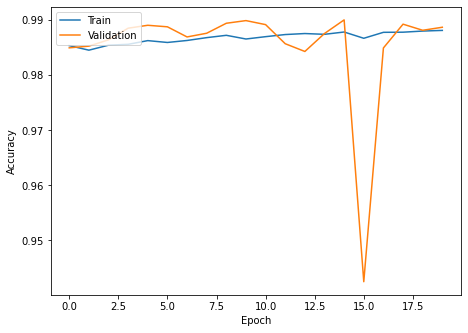

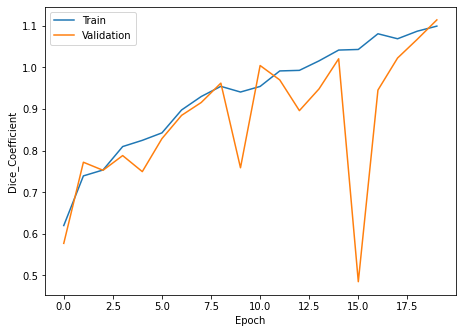

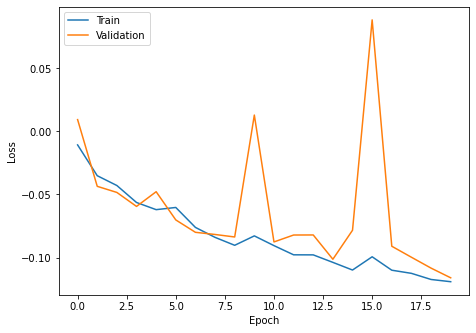

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_v2.h5')

# Training model on BraTS2020 Dataset using "Adamax" as an optimizer.


Let us define the optimizer to be used for training. Here, we will be using Adamax as an optimizer with Learning rate = 0.001.

In [ ]:
model = ResUNet()
LR = 0.001
Adamax = keras.optimizers.Adamax(LR)
model.compile(optimizer = Adamax, loss = dice_coef_loss, metrics=['accuracy', dice_coef, precision])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=20,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/20


2022-12-13 00:29:18.048718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


66/66 [==============================] - 1071s 16s/step - loss: 0.7293 - accuracy: 0.9160 - dice_coef: 0.2707 - precision: 0.0967 - val_loss: 0.8536 - val_accuracy: 0.7736 - val_dice_coef: 0.1457 - val_precision: 0.0412
Epoch 2/20
66/66 [==============================] - 1132s 17s/step - loss: 0.6125 - accuracy: 0.9593 - dice_coef: 0.3875 - precision: 0.1561 - val_loss: 0.9717 - val_accuracy: 0.9179 - val_dice_coef: 0.0274 - val_precision: 0.0155
Epoch 3/20
66/66 [==============================] - 1158s 18s/step - loss: 0.3790 - accuracy: 0.9814 - dice_coef: 0.6215 - precision: 0.4112 - val_loss: 0.9926 - val_accuracy: 0.9898 - val_dice_coef: 0.0072 - val_precision: 167647056.0000
Epoch 4/20
66/66 [==============================] - 1126s 17s/step - loss: 0.2129 - accuracy: 0.9817 - dice_coef: 0.7875 - precision: 0.4699 - val_loss: 0.7485 - val_accuracy: 0.9899 - val_dice_coef: 0.2442 - val_precision: 0.8502
Epoch 5/20
66/66 [==============================] - 1130s 17s/step - loss: 0.12

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_adamax.h5')

Evaluating the model on the training and testing data.

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 49s 3s/step - loss: -0.1486 - accuracy: 0.9899 - dice_coef: 1.1502 - precision: 0.9153


[-0.14864660799503326,
 0.9899458885192871,
 1.1502188444137573,
 0.9152752757072449]

# Visualising the training results by plotting each one of them.

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

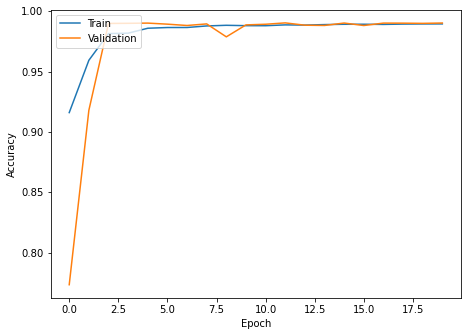

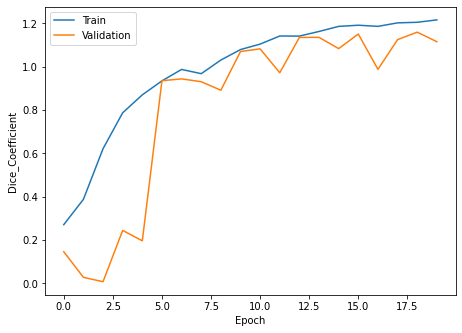

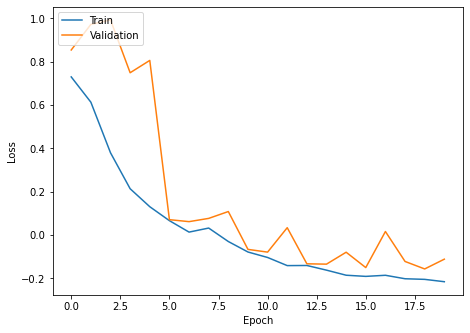

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_adamax_v2.h5')

# Training model on BraTS2020 Dataset using "SGD" as an optimizer.



Let us define the optimizer to be used for training. Here, we will be using SGD as an optimizer with Learning rate = 0.0001.

In [ ]:
model = ResUNet()
LR = 0.0001
sgd = keras.optimizers.SGD(LR)
model.compile(optimizer = sgd, loss = dice_coef_loss, metrics=['accuracy', dice_coef, precision])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 240, 240, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 240, 240, 16  64         ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

In [ ]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=20,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/20
66/66 [==============================] - 1078s 16s/step - loss: 0.9548 - accuracy: 0.8284 - dice_coef: 0.0452 - precision: 0.0400 - val_loss: 0.9560 - val_accuracy: 0.8776 - val_dice_coef: 0.0435 - val_precision: 0.0659
Epoch 2/20
66/66 [==============================] - 1067s 16s/step - loss: 0.9491 - accuracy: 0.8222 - dice_coef: 0.0510 - precision: 0.0423 - val_loss: 0.9611 - val_accuracy: 0.9167 - val_dice_coef: 0.0384 - val_precision: 0.0796
Epoch 3/20
66/66 [==============================] - 1094s 17s/step - loss: 0.9414 - accuracy: 0.8120 - dice_coef: 0.0586 - precision: 0.0441 - val_loss: 0.9541 - val_accuracy: 0.9010 - val_dice_coef: 0.0452 - val_precision: 0.0745
Epoch 4/20
66/66 [==============================] - 1095s 17s/step - loss: 0.9345 - accuracy: 0.8016 - dice_coef: 0.0655 - precision: 0.0445 - val_loss: 0.9437 - val_accuracy: 0.8688 - val_dice_coef: 0.0555 - val_precision: 0.0639
Epoch 5/20
66/66 [==============================] - 1080s 16s/step - loss: 0

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_sgd.h5')

Evaluating the model on the training and testing data.

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 48s 3s/step - loss: 0.8774 - accuracy: 0.7631 - dice_coef: 0.1218 - precision: 0.0457


[0.8773949146270752,
 0.7630565166473389,
 0.1218208447098732,
 0.045661091804504395]

# Visualising the training results by plotting each one of them.

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

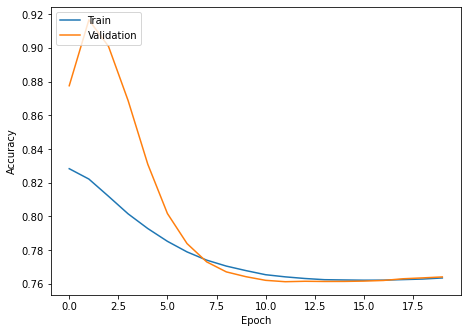

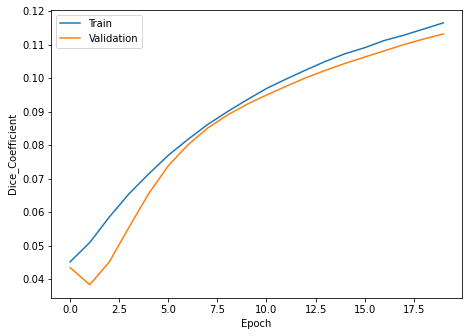

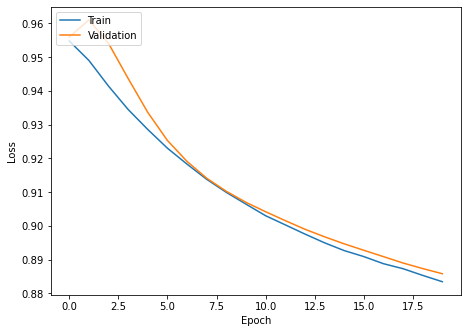

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
model.save('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_sgd_v2.h5')

After evaluating the performance of the above models trained using different optimizers i.e. Adam, Adamax, and SGD, we can see that the performance of the model with Adamax as an optimizer is better than the other two models.

Therefore, let us now load and use the Adamax model for testing out the predictions.

# Now predicting on images.

In [ ]:
from keras.models import load_model

In [ ]:
#For predictions you do not need to compile the model, so ...
model_final = load_model('/Users/nabeel/Downloads/archive/BraTS2020_TrainingData/BraTs2020_adamax_v2.h5', compile=False)

In [ ]:
X_train=X_test=Y_train=Y_test=0

In [ ]:
pref_Tumor = model_final.predict(T1_image)

2022-12-18 12:04:39.817690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


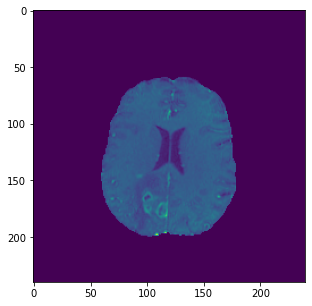

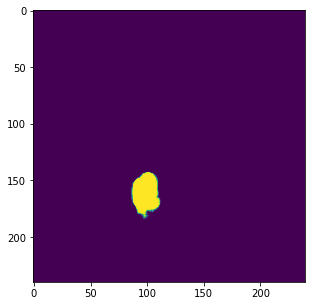

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = T1_image[400,:,:]
imgplot = plt.imshow(immmg)
plt.show()

fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[400,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

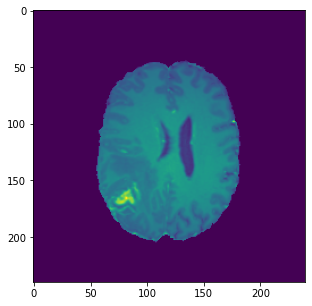

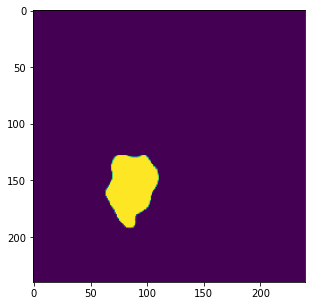

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = T1_image[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

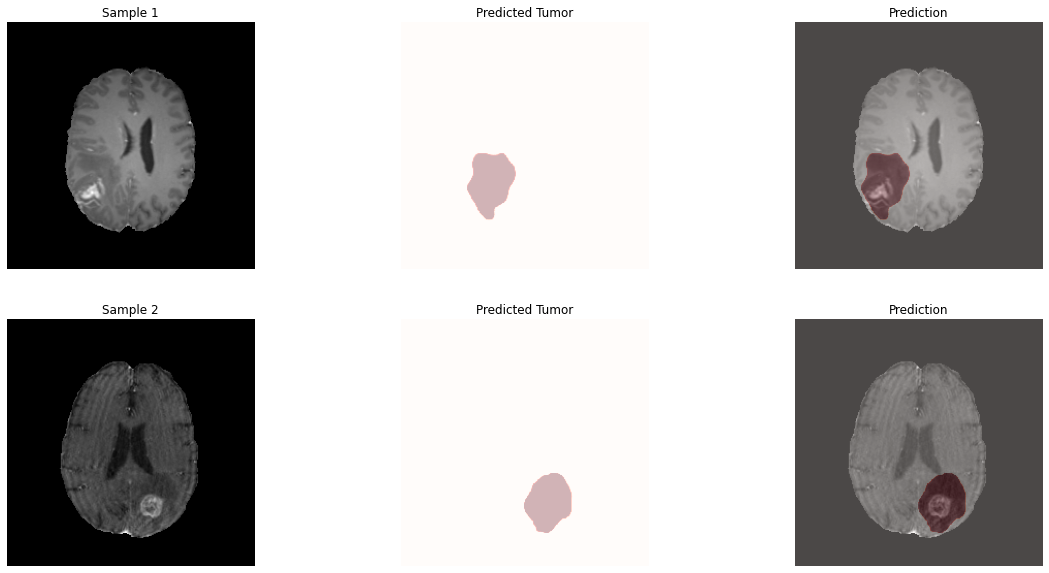

In [ ]:
plt.figure(figsize=(20,10))


plt.subplot(231)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(T1_image[250,:,:]),cmap='gray')


plt.subplot(232)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(233)
plt.title('Prediction')
plt.axis('off')
plt.imshow(np.squeeze(T1_image[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

#########

plt.subplot(234)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(T1_image[550,:,:]),cmap='gray')


plt.subplot(235)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(236)
plt.title('Prediction')
plt.axis('off')
plt.imshow(np.squeeze(T1_image[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')
